In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
valid_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader

In [2]:
from src.collectors import DataCollector

COLLECTOR = DataCollector(metric_kwargs={'metric': 'minkowski', 'p': 1})
NUM_EPOCHS = 5

In [3]:
# After https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
# and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet

from tqdm import tqdm


def train(model, loaders, criterion, optimizer, scheduler, num_epochs=5, device=torch.device('cpu')):
    model.to(device)

    for epoch in range(num_epochs):
        COLLECTOR.current_epoch = epoch

        train_loss, train_acc = one_epoch('train', model, loaders['train'], criterion, scheduler, optimizer, epoch, device)
        valid_loss, valid_acc = one_epoch('valid', model, loaders['valid'], criterion, scheduler, optimizer, epoch, device)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_acc}")


def one_epoch(phase, model, loader, criterion, scheduler, optimizer, epoch_idx, device):
    if phase == 'train':
        model.train()
    elif phase == 'valid':
        model.eval()
    else:
        raise ValueError(
            f"Phase {phase} is not a proper learning phase (use 'train' or 'valid')!")

    running_loss = 0.0
    running_corrects = 0
    dataset_size = 0

    for batch, (inputs, labels) in enumerate(tqdm(loader)):
        COLLECTOR.current_batch = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        dataset_size += inputs.size(0)

        if phase == 'train' and scheduler is not None:
            scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects / dataset_size

    return epoch_loss, epoch_acc

100%|██████████| 40/40 [00:01<00:00, 26.44it/s]


Epoch [1/5], Loss: 0.6281, Accuracy: 0.7657999992370605
Epoch [1/5], Loss: 2.7095, Accuracy: 0.5113999843597412


100%|██████████| 40/40 [00:01<00:00, 28.34it/s]


Epoch [2/5], Loss: 0.3985, Accuracy: 0.8549000024795532
Epoch [2/5], Loss: 0.4477, Accuracy: 0.842199981212616


100%|██████████| 40/40 [00:01<00:00, 28.22it/s]


Epoch [3/5], Loss: 0.3489, Accuracy: 0.8736166954040527
Epoch [3/5], Loss: 0.8572, Accuracy: 0.727400004863739


100%|██████████| 40/40 [00:01<00:00, 28.18it/s]


Epoch [4/5], Loss: 0.6075, Accuracy: 0.7866500020027161
Epoch [4/5], Loss: 1.0286, Accuracy: 0.6940000057220459


100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Epoch [5/5], Loss: 0.4631, Accuracy: 0.8529166579246521
Epoch [5/5], Loss: 0.4759, Accuracy: 0.8532999753952026


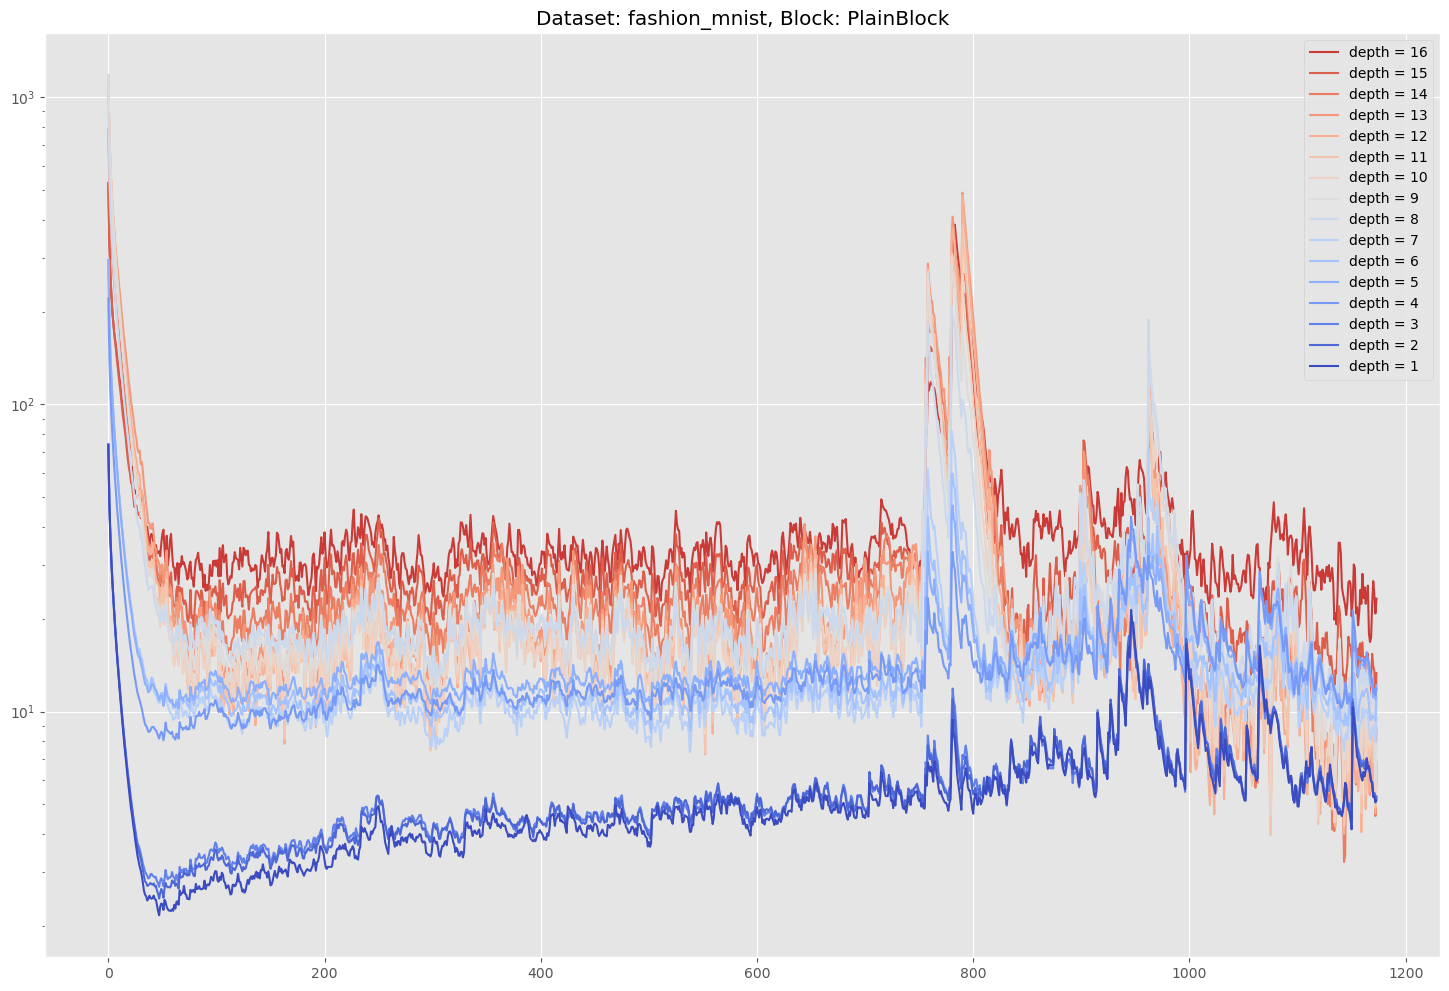

100%|██████████| 40/40 [00:01<00:00, 26.94it/s]


Epoch [1/5], Loss: 0.4610, Accuracy: 0.8335666656494141
Epoch [1/5], Loss: 0.5007, Accuracy: 0.8274000287055969


100%|██████████| 40/40 [00:01<00:00, 27.38it/s]


Epoch [2/5], Loss: 0.3095, Accuracy: 0.8871333599090576
Epoch [2/5], Loss: 0.3555, Accuracy: 0.8662999868392944


100%|██████████| 40/40 [00:01<00:00, 27.21it/s]


Epoch [3/5], Loss: 0.2629, Accuracy: 0.9020333290100098
Epoch [3/5], Loss: 0.2945, Accuracy: 0.8948000073432922


100%|██████████| 40/40 [00:01<00:00, 27.61it/s]


Epoch [4/5], Loss: 0.2345, Accuracy: 0.9110333323478699
Epoch [4/5], Loss: 0.3359, Accuracy: 0.8795999884605408


100%|██████████| 40/40 [00:01<00:00, 27.28it/s]


Epoch [5/5], Loss: 0.2162, Accuracy: 0.9194666743278503
Epoch [5/5], Loss: 0.3404, Accuracy: 0.8752999901771545


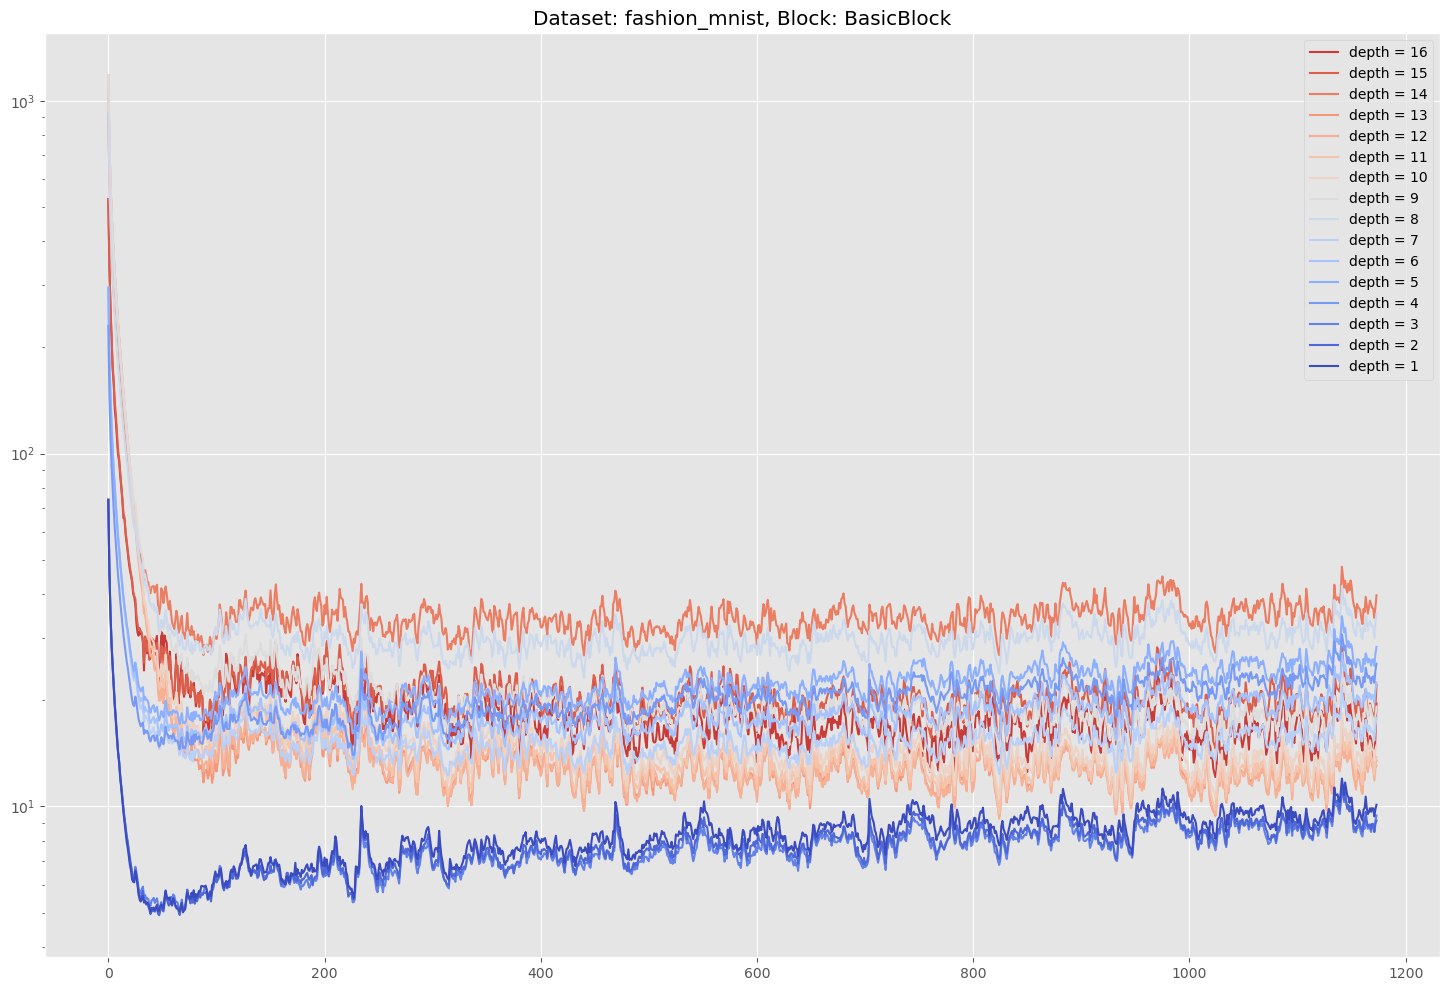

100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


Epoch [1/5], Loss: 0.5884, Accuracy: 0.7912333607673645
Epoch [1/5], Loss: 0.3920, Accuracy: 0.8525999784469604


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch [2/5], Loss: 0.3370, Accuracy: 0.8754333257675171
Epoch [2/5], Loss: 0.3605, Accuracy: 0.8680999875068665


100%|██████████| 40/40 [00:03<00:00, 11.27it/s]


Epoch [3/5], Loss: 0.2839, Accuracy: 0.8938000202178955
Epoch [3/5], Loss: 0.3434, Accuracy: 0.8752999901771545


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch [4/5], Loss: 0.2533, Accuracy: 0.9049833416938782
Epoch [4/5], Loss: 0.3425, Accuracy: 0.8772000074386597


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch [5/5], Loss: 0.2261, Accuracy: 0.9150000214576721
Epoch [5/5], Loss: 0.3574, Accuracy: 0.8755999803543091


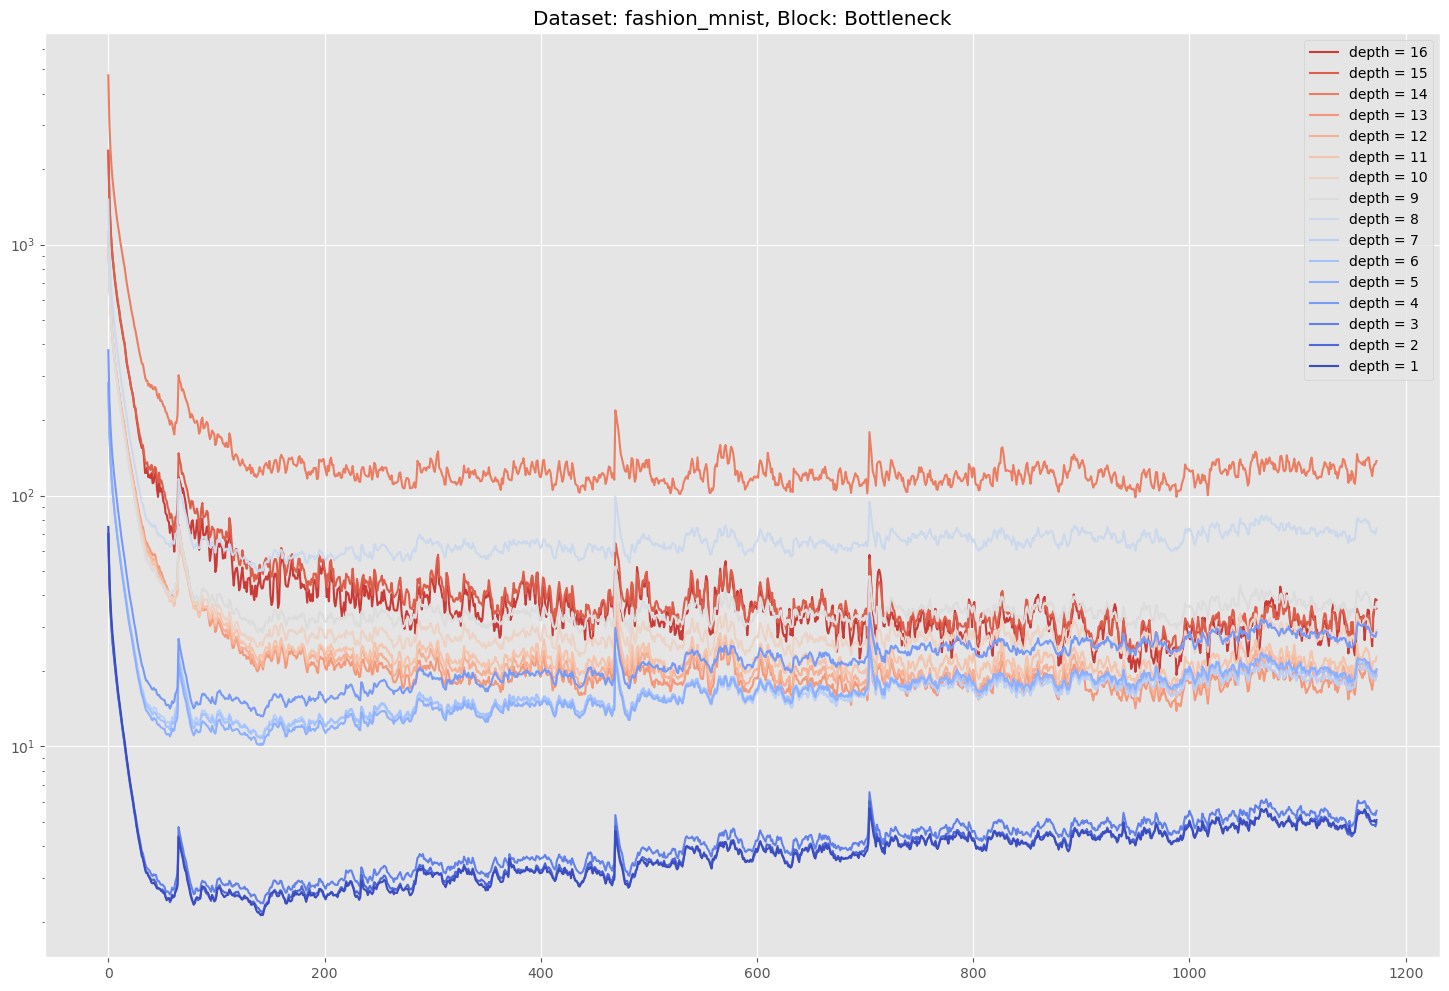

100%|██████████| 40/40 [00:01<00:00, 28.12it/s]


Epoch [1/5], Loss: 0.3470, Accuracy: 0.8880333304405212
Epoch [1/5], Loss: 1.8215, Accuracy: 0.4740999937057495


100%|██████████| 40/40 [00:01<00:00, 28.04it/s]


Epoch [2/5], Loss: 0.0998, Accuracy: 0.9728000164031982
Epoch [2/5], Loss: 0.7690, Accuracy: 0.751800000667572


100%|██████████| 40/40 [00:01<00:00, 28.37it/s]


Epoch [3/5], Loss: 0.0669, Accuracy: 0.9819333553314209
Epoch [3/5], Loss: 0.2213, Accuracy: 0.9539999961853027


100%|██████████| 40/40 [00:01<00:00, 27.92it/s]


Epoch [4/5], Loss: 0.0563, Accuracy: 0.9852333068847656
Epoch [4/5], Loss: 0.4762, Accuracy: 0.815500020980835


100%|██████████| 40/40 [00:01<00:00, 27.99it/s]


Epoch [5/5], Loss: 0.0412, Accuracy: 0.9892833232879639
Epoch [5/5], Loss: 0.0934, Accuracy: 0.9797000288963318


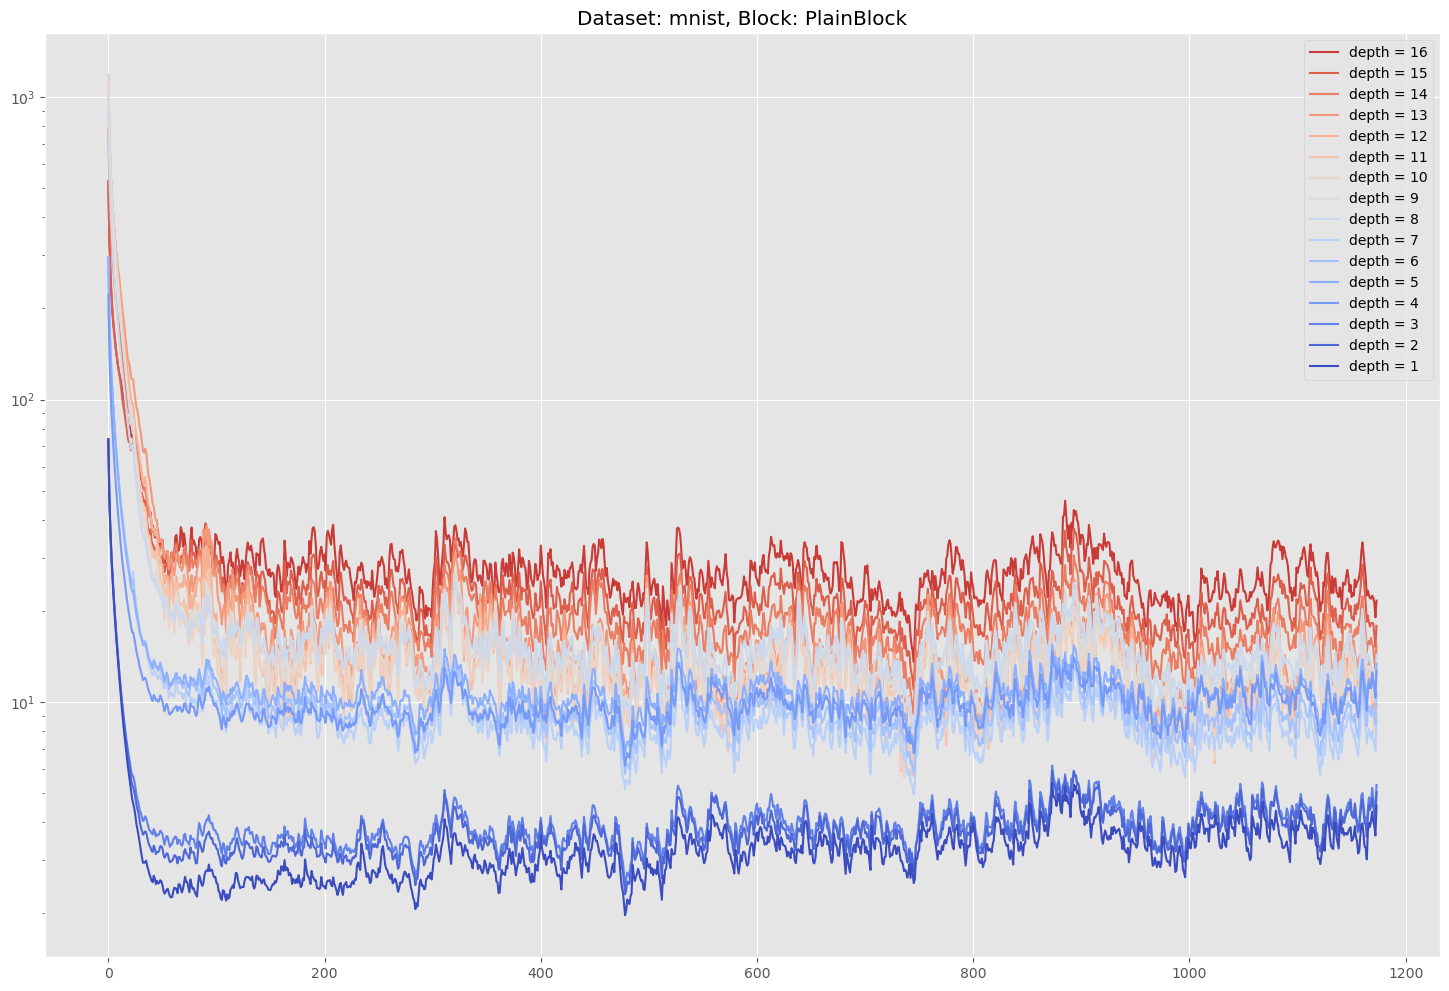

100%|██████████| 40/40 [00:01<00:00, 27.25it/s]


Epoch [1/5], Loss: 0.1457, Accuracy: 0.9547833204269409
Epoch [1/5], Loss: 0.1002, Accuracy: 0.968500018119812


100%|██████████| 40/40 [00:01<00:00, 27.11it/s]


Epoch [2/5], Loss: 0.0510, Accuracy: 0.9846000075340271
Epoch [2/5], Loss: 0.1125, Accuracy: 0.9631999731063843


100%|██████████| 40/40 [00:01<00:00, 27.02it/s]


Epoch [3/5], Loss: 0.0387, Accuracy: 0.9883000254631042
Epoch [3/5], Loss: 0.0411, Accuracy: 0.9868000149726868


100%|██████████| 40/40 [00:01<00:00, 27.21it/s]


Epoch [4/5], Loss: 0.0322, Accuracy: 0.9899333119392395
Epoch [4/5], Loss: 0.0508, Accuracy: 0.9851999878883362


100%|██████████| 40/40 [00:01<00:00, 27.05it/s]


Epoch [5/5], Loss: 0.0291, Accuracy: 0.9907666444778442
Epoch [5/5], Loss: 0.0370, Accuracy: 0.9883999824523926


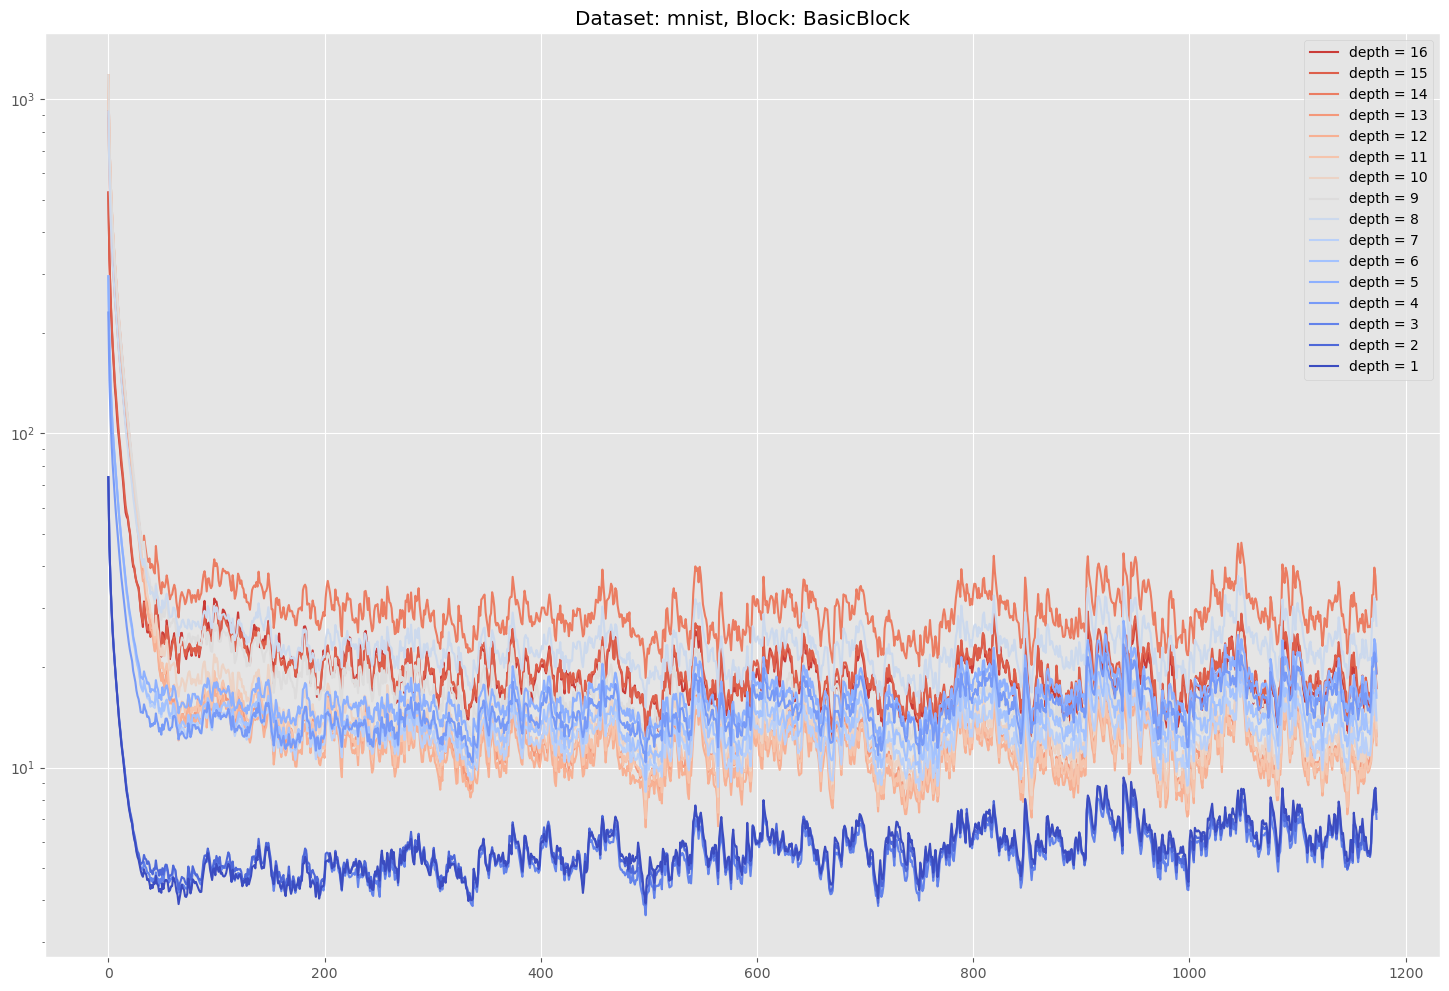

100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch [1/5], Loss: 0.2986, Accuracy: 0.9081833362579346
Epoch [1/5], Loss: 0.0781, Accuracy: 0.9758999943733215


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch [2/5], Loss: 0.0621, Accuracy: 0.9807999730110168
Epoch [2/5], Loss: 0.0761, Accuracy: 0.9785000085830688


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch [3/5], Loss: 0.0397, Accuracy: 0.9870333075523376
Epoch [3/5], Loss: 0.0872, Accuracy: 0.9746000170707703


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch [4/5], Loss: 0.0320, Accuracy: 0.9896833300590515
Epoch [4/5], Loss: 0.0873, Accuracy: 0.9764999747276306


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch [5/5], Loss: 0.0231, Accuracy: 0.9924833178520203
Epoch [5/5], Loss: 0.0552, Accuracy: 0.9850000143051147


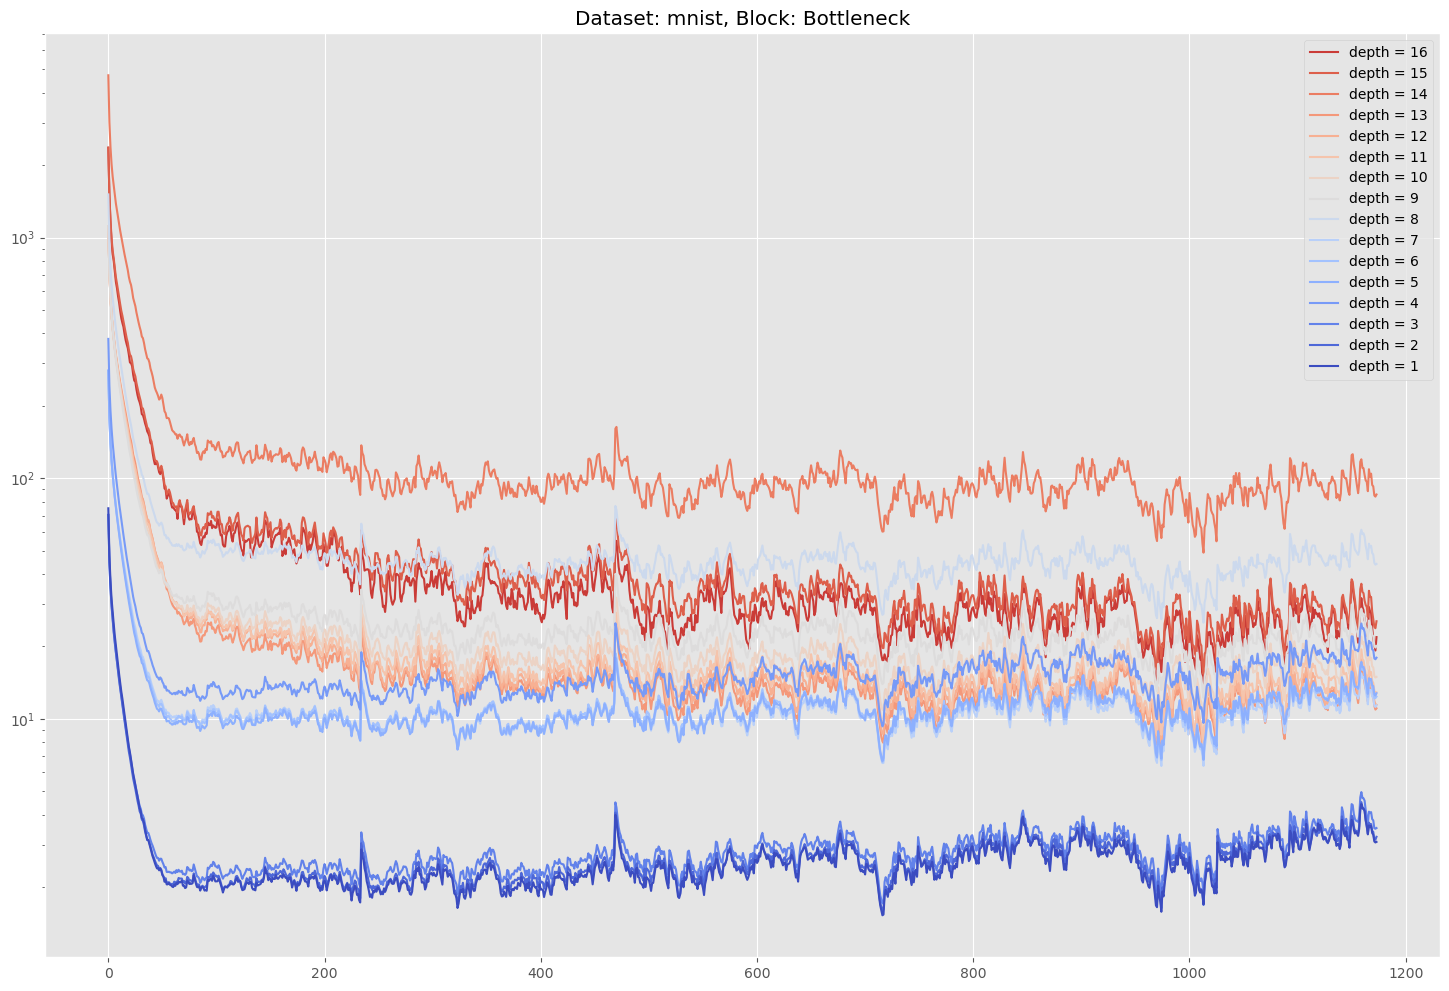

In [4]:
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from src.modules.blocks import PlainBlock, BasicBlock, Bottleneck
from src.modules.models import ResNet
from src.datasets import fashion_mnist, mnist

plt.style.use('ggplot')

for dataset in [fashion_mnist, mnist]:
    train_loader, valid_loader = dataset()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader
    
    for block in [PlainBlock, BasicBlock, Bottleneck]:
        model = ResNet(block=block, in_channels=1, layers=[3, 4, 6, 3], num_classes=10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())
        scheduler = None # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        device = torch.device("mps")
        
        DataCollector.reset_instances()
        COLLECTOR = DataCollector(metric_kwargs={'metric': 'minkowski', 'p': 1})
        
        train(model, loaders, criterion, optimizer, scheduler, NUM_EPOCHS, device)
        
        plt.figure(figsize=(18, 12))
        plt.title(f"Dataset: {dataset.__name__}, Block: {block.__name__}")
        for depth, differences in COLLECTOR.next_differences.items():
            plt.plot(differences, label=f"depth = {depth}", color=plt.cm.coolwarm((depth-1) / model.max_depth))
            
        plt.yscale('log')
        plt.legend()
        plt.show()

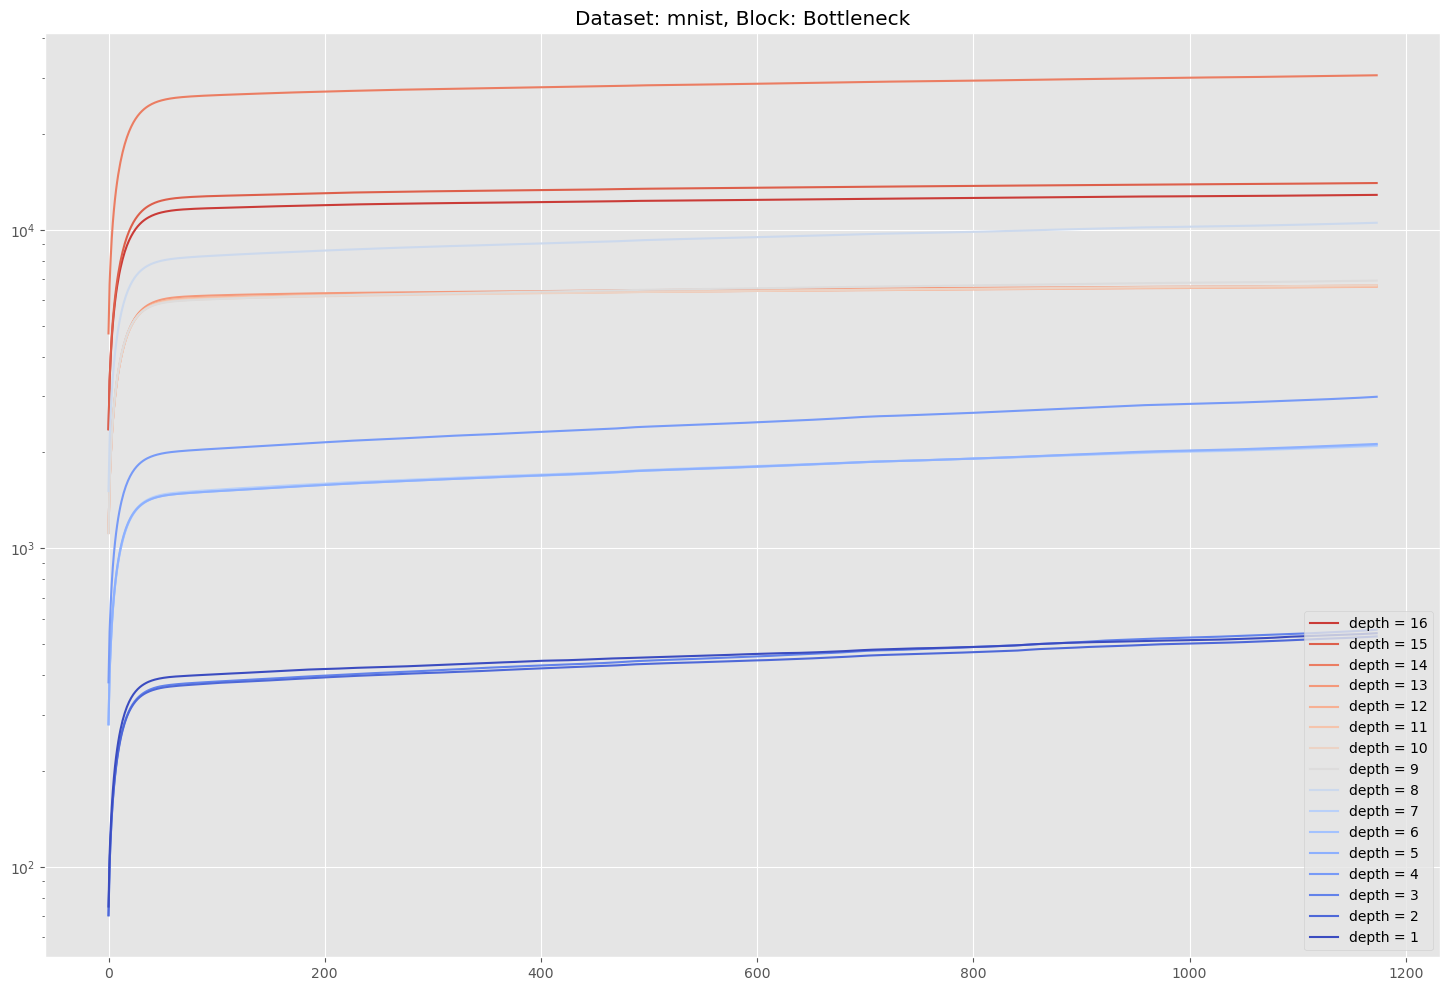

In [14]:
plt.figure(figsize=(18, 12))
plt.title(f"Dataset: {dataset.__name__}, Block: {block.__name__}")
for depth, differences in COLLECTOR.init_differences.items():
    plt.plot(differences, label=f"depth = {depth}", color=plt.cm.coolwarm((depth-1) / model.max_depth))
    # plt.plot(differences, label=f"depth = {depth}", color=plt.cm.magma((depth-1) / model.max_depth))
    
plt.yscale('log')
plt.legend()
plt.show()